In [2]:
# --- Part 0: Setup & Installations ---

print("Updating apt-get...")
!apt-get update -y --quiet

print("Installing OS-level dependencies (libgdal-dev)...")
!apt-get install -y libgdal-dev --quiet


print("\nInstalling fiona...")
!pip install fiona --quiet

print("Installing geopandas...")
!pip install geopandas --quiet

print("Installing osmnx...")
!pip install osmnx --quiet

print("Installing prophet...")
!pip install prophet --quiet

print("Installing shap...")
!pip install shap --quiet

print("Installing sklearn (scikit-learn)...")
!pip install scikit-learn --quiet 

# Added wordcloud which was missing from the original install list
print("Installing pandas, numpy, matplotlib, seaborn, nltk, and wordcloud...")
!pip install pandas numpy matplotlib seaborn nltk wordcloud --quiet

print("\nAll packages should now be installed.")

Updating apt-get...
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Installing OS-level dependencies (libgdal-dev)...
Readi

In [3]:
# --- Import all main libraries ---
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import fiona 
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import warnings

# Advanced Analytics Imports
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import shap

# NLTK Downloads for text processing
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Settings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 7)

print("All libraries imported successfully.")

All libraries imported successfully.


In [4]:
# --- Helper Functions from original notebook ---

def calculate_haversine_distance(row, center_lat=13.00, center_lon=77.59):
    """Calculates distance (km) between a point and the Bangalore center."""
    R = 6371  # Earth radius in kilometers
    lon1, lat1 = row.geometry.x, row.geometry.y
    phi1 = radians(lat1)
    phi2 = radians(center_lat)
    delta_phi = radians(center_lat - lat1)
    delta_lambda = radians(center_lon - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def clean_station_names(name):
    """Normalizes station names."""
    name = str(name).lower()
    name = name.replace('.', '').replace('-', ' ').replace('(', '').replace(')', '').strip()
    name = ' '.join(name.split()) 
    # This map is key for merging names that are written differently
    name_map = {
        'nadaprabhu kempegowda station majestic': 'majestic', 
        'sir m vishweshwaraiah terminal': 'sv terminal', 
        'baiyappanahalli': 'byappanahalli', 
        'mg road': 'mgroad',
        'mgroad': 'mgroad',
    }
    return name_map.get(name, name)

# --- 1. Define Data Paths ---
station_path = '/kaggle/input/bengaluru-metro-last-mile-data/bengaluru-metro-stations.kml'
ridership_path = '/kaggle/input/bengaluru-metro-last-mile-data/station-hourly.csv'
tweet_file_path = '/kaggle/input/bangalore-tweets/finalbangalore-1.csv'

# --- 2. Load Data ---
# Enable KML driver for geopandas
fiona.drvsupport.supported_drivers['KML'] = 'rw'
stations_gdf = gpd.read_file(station_path, driver='KML')
ridership_df = pd.read_csv(ridership_path, sep=';')
try:
    tweets_df = pd.read_csv(tweet_file_path, on_bad_lines='skip')
except Exception as e:
    tweets_df = pd.read_csv(tweet_file_path, on_bad_lines='skip', encoding='latin-1')

# Aggregate Ridership
station_totals = ridership_df.groupby('Station')['Ridership'].sum().reset_index()
station_totals.columns = ['Name', 'Total_Entries']
station_totals['Total_Entries'] = pd.to_numeric(station_totals['Total_Entries'], errors='coerce')
station_totals.dropna(subset=['Total_Entries'], inplace=True)

# --- 3. Prepare & Clean Names ---
stations_gdf['accessibility_score_km'] = stations_gdf.apply(calculate_haversine_distance, axis=1)
stations_gdf['Name_clean'] = stations_gdf['Name'].str.split(',').str[0].str.strip().apply(clean_station_names)
# Clean the station names from the ridership file, removing line info like ' (Purple Line)'
station_totals['Name_clean'] = station_totals['Name'].str.split(r'\s\(', n=1, expand=True)[0].str.strip().apply(clean_station_names)

# --- 4. Final Merge ---
master_gdf = pd.merge(
    stations_gdf[['Name', 'Description', 'geometry', 'accessibility_score_km', 'Name_clean']],
    station_totals[['Name_clean', 'Total_Entries']],
    on='Name_clean',
    how='inner' 
)
master_gdf = master_gdf.drop_duplicates(subset=['Name_clean'])
master_gdf.dropna(subset=['Total_Entries'], inplace=True)
master_gdf = master_gdf[master_gdf['Total_Entries'] > 0]

print(f"\n--- Merge Result ---")
print(f"Master GDF created with {len(master_gdf)} matching stations.")
master_gdf.head()


--- Merge Result ---
Master GDF created with 48 matching stations.


,Name,Description,geometry,accessibility_score_km,Name_clean,Total_Entries
0,Hopefarm Channasandra,,POINT Z (77.75376 12.98711 0),17.800619,hopefarm channasandra,45654
1,Kadugodi Tree Park,,POINT Z (77.74703 12.98568 0),17.087879,kadugodi tree park,209638
2,Pattandur Agrahara,,POINT Z (77.73777 12.98764 0),16.069622,pattandur agrahara,180496
3,Nallurahalli,,POINT Z (77.72488 12.97664 0),14.843770,nallurahalli,137855
4,Kundalahalli,,POINT Z (77.71556 12.97759 0),13.830516,kundalahalli,137566


In [5]:
# --- 3. Define the *FIXED* "Walkability" Function ---

# Project to a meter-based CRS for accurate distance calculation with osmnx
print("Projecting GDF to EPSG:3857 for walkability analysis...")
master_gdf_4326 = master_gdf.to_crs("epsg:4326") # Keep a 4326 copy for later
master_gdf = master_gdf.to_crs("epsg:3857")

def get_walkability_score(station_geometry_3857):
    try:
        # 1. Create a GeoSeries from the single point, specifying its current CRS (3857)
        temp_gseries = gpd.GeoSeries([station_geometry_3857], crs="epsg:3857")
        
        # 2. Now, re-project this valid GeoSeries back to Lat/Lon (4326) for osmnx
        station_latlon = temp_gseries.to_crs("epsg:4326").iloc[0]
        
        # 3. Use the (Lat, Lon) coordinates as osmnx expects
        G = ox.graph_from_point((station_latlon.y, station_latlon.x), 
                                dist=1000, 
                                network_type='walk')
        
        # 4. Get edges and sum their length (updated syntax)
        edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
        return edges['length'].sum()
    except Exception as e:
        return np.nan # Return NaN for errors

# --- 4. Calculate Score for Each Station ---
print("Calculating walkability scores... This will take several minutes.")
master_gdf['walkability_score'] = master_gdf['geometry'].apply(get_walkability_score)
print("Calculation complete.")

# --- 5. Final Output ---
print("\n--- Dataframe with Walkability & Centrality Scores ---")
master_gdf.dropna(subset=['walkability_score'], inplace=True)
print(f"Successfully calculated scores for {len(master_gdf)} stations.")
master_gdf.head()

Projecting GDF to EPSG:3857 for walkability analysis...
Calculating walkability scores... This will take several minutes.
Calculation complete.

--- Dataframe with Walkability & Centrality Scores ---
Successfully calculated scores for 48 stations.


,Name,Description,geometry,accessibility_score_km,Name_clean,Total_Entries,walkability_score
0,Hopefarm Channasandra,,POINT Z (8655508.77 1458259.955 0),17.800619,hopefarm channasandra,45654,90228.738954
1,Kadugodi Tree Park,,POINT Z (8654759.367 1458095.927 0),17.087879,kadugodi tree park,209638,76913.156222
2,Pattandur Agrahara,,POINT Z (8653729.172 1458320.126 0),16.069622,pattandur agrahara,180496,33253.434610
3,Nallurahalli,,POINT Z (8652294.565 1457063.664 0),14.843770,nallurahalli,137855,45259.140002
4,Kundalahalli,,POINT Z (8651256.41 1457172.555 0),13.830516,kundalahalli,137566,74216.218002


Preparing hourly data for Prophet...
Time-series data prepared with 432 hourly entries.
                   ds    y
0 2025-08-01 00:00:00   21
1 2025-08-01 01:00:00    0
2 2025-08-01 02:00:00    0
3 2025-08-01 03:00:00    0
4 2025-08-01 04:00:00  604


14:17:42 - cmdstanpy - INFO - Chain [1] start processing
14:17:42 - cmdstanpy - INFO - Chain [1] done processing


Making future predictions...
Plotting forecast...


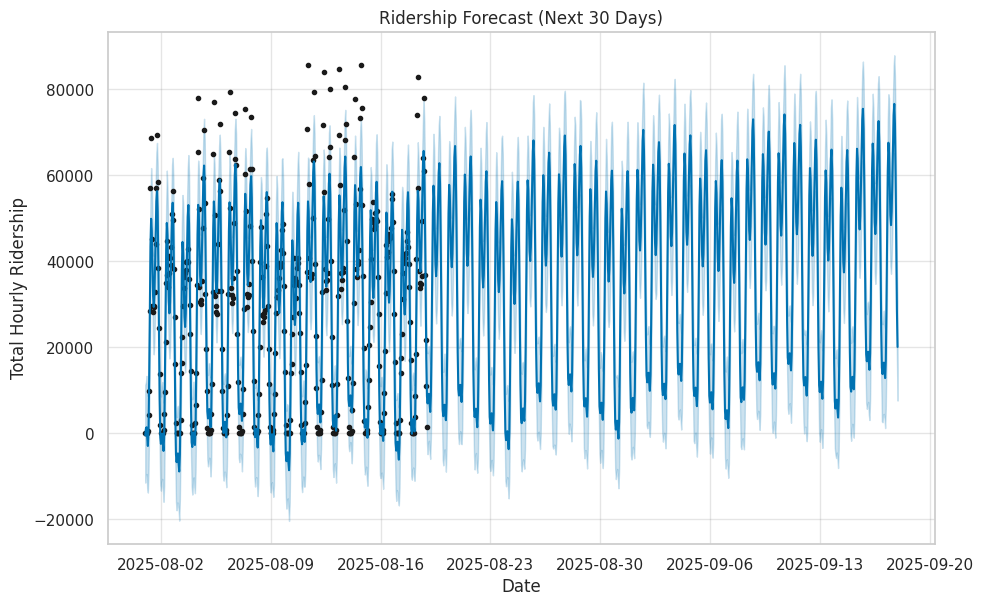

Plotting forecast components (Trend, Weekly, Daily)...


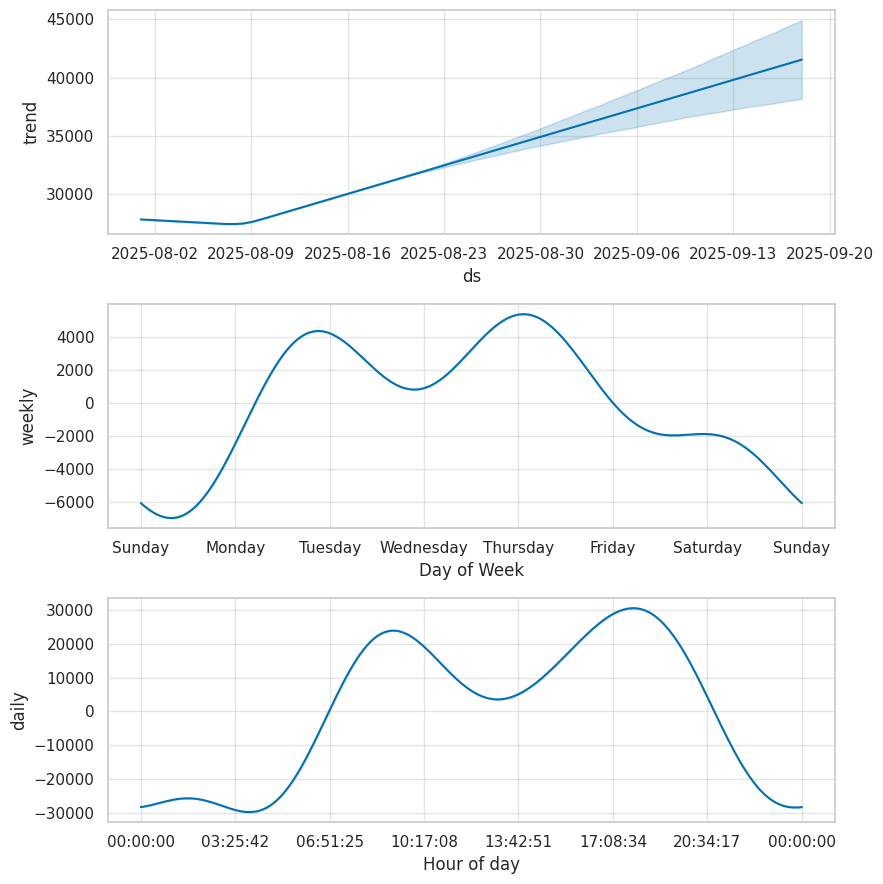

In [6]:
# --- 1. Load and Prepare Time-Series Data ---
print("Preparing hourly data for Prophet...")

# Load the CSV *without* parsing dates
df_hourly = pd.read_csv(ridership_path, sep=';')

# --- FIX: Manually create a combined datetime column ---
try:
    # Combine the 'Date' (string) and 'Hour' (int) columns into a single string
    df_hourly['ds_str'] = df_hourly['Date'].astype(str) + ' ' + df_hourly['Hour'].astype(str)
    
    # Convert the new string column to datetime, specifying the *exact* format
    df_hourly['ds'] = pd.to_datetime(df_hourly['ds_str'], format='%Y-%m-%d %H')

except KeyError:
    print("Column 'Date' or 'Hour' not found. Please re-check CSV headers.")
    df_ts = pd.DataFrame() # Create empty dataframe to skip
else:
    # Aggregate by the new 'ds' column across ALL stations
    df_ts = df_hourly.groupby('ds')['Ridership'].sum().reset_index()

    # Rename the 'Ridership' column for Prophet
    df_ts.rename(columns={'Ridership': 'y'}, inplace=True)
    df_ts = df_ts.dropna()

    print(f"Time-series data prepared with {len(df_ts)} hourly entries.")
    print(df_ts.head())


# --- 2. Run Prophet (only if data loading was successful) ---
if not df_ts.empty:
    # --- 2. Initialize and Fit Prophet Model ---
    m = Prophet(daily_seasonality=True, weekly_seasonality=True)
    m.fit(df_ts)

    # --- 3. Create Future Dataframe & Predict ---
    future = m.make_future_dataframe(periods=30 * 24, freq='H')
    print("Making future predictions...")
    forecast = m.predict(future)

    # --- 4. Plot Results ---
    print("Plotting forecast...")
    fig1 = m.plot(forecast)
    plt.title("Ridership Forecast (Next 30 Days)")
    plt.xlabel("Date")
    plt.ylabel("Total Hourly Ridership")
    plt.show()

    print("Plotting forecast components (Trend, Weekly, Daily)...")
    fig2 = m.plot_components(forecast)
    plt.show()

else:
    print("Time-series dataframe is empty or failed to load, skipping Prophet forecast.")

In [7]:
# --- 1. Load and Prepare Tweet Data ---
print("Loading pre-scraped tweet dataset for sentiment analysis...")

try:
    # Load the CSV
    try:
        tweets_df = pd.read_csv(tweet_file_path, on_bad_lines='skip')
    except Exception as e:
        tweets_df = pd.read_csv(tweet_file_path, on_bad_lines='skip', encoding='latin-1')

    tweets_df = tweets_df[tweets_df['content'].notna()]
    print(f"Loaded {len(tweets_df)} total tweets.")

    # --- NEW: Extract station from tweet content ---
    # Get a list of all unique station names from our master_gdf
    # Sort by length (longest first) to match 'j p nagar' before 'nagar'
    station_name_list = sorted(master_gdf['Name_clean'].unique(), key=len, reverse=True)

    def find_station_in_tweet(tweet_content):
        """
        Finds the first matching (longest) station name in a tweet's text.
        """
        tweet_content_lower = str(tweet_content).lower()
        
        # Manual overrides for common names that cleaning might miss
        if 'mg road' in tweet_content_lower or 'm g road' in tweet_content_lower:
            return 'mgroad'
        if 'majestic' in tweet_content_lower or 'kempegowda' in tweet_content_lower:
            return 'majestic'
        
        # Iterate through the official *cleaned* list
        for station_name in station_name_list:
            # station_name is already clean (e.g., 'jp nagar')
            if station_name in tweet_content_lower:
                return station_name # Return the first (longest) match
        return np.nan

    print("Attempting to link tweets to stations...")
    tweets_df['station'] = tweets_df['content'].apply(find_station_in_tweet)
    
    # --- Filter tweets to ONLY those we could link to a station ---
    tweets_df = tweets_df.dropna(subset=['station'])
    print(f"Successfully linked {len(tweets_df)} tweets to specific stations.")
    
    if tweets_df.empty:
        raise ValueError("No tweets could be linked to any known station. Aborting sentiment analysis.")

    # --- 2. Text Pre-processing (continues as before) ---
    stop_words = set(stopwords.words('english'))
    
    # Add custom stop words relevant to the topic
    custom_stops = ['bangalore', 'bengaluru', 'metro', 'station', 'rt', 'https_t', 'co', 'amp', 'u']
    stop_words.update(custom_stops)
    
    def clean_tweet(text):
        text = str(text).lower()
        text = ' '.join([word for word in text.split() if word not in stop_words and word.isalpha() and len(word) > 2])
        return text
    
    tweets_df['cleaned_tweet'] = tweets_df['content'].apply(clean_tweet)
    
    # Filter out tweets that became empty *after* cleaning
    tweets_df = tweets_df[tweets_df['cleaned_tweet'] != '']
    print(f"{len(tweets_df)} linked tweets remain after text cleaning.")

except (KeyError, ValueError, NameError) as e:
    print(f"Error: {e}. Cannot perform sentiment analysis.")
    # Create empty df with expected columns to prevent later cells from failing
    tweets_df = pd.DataFrame(columns=['cleaned_tweet', 'station'])

Loading pre-scraped tweet dataset for sentiment analysis...
Loaded 372823 total tweets.
Attempting to link tweets to stations...
Successfully linked 2385 tweets to specific stations.
2385 linked tweets remain after text cleaning.


Generating word cloud from complaint data...


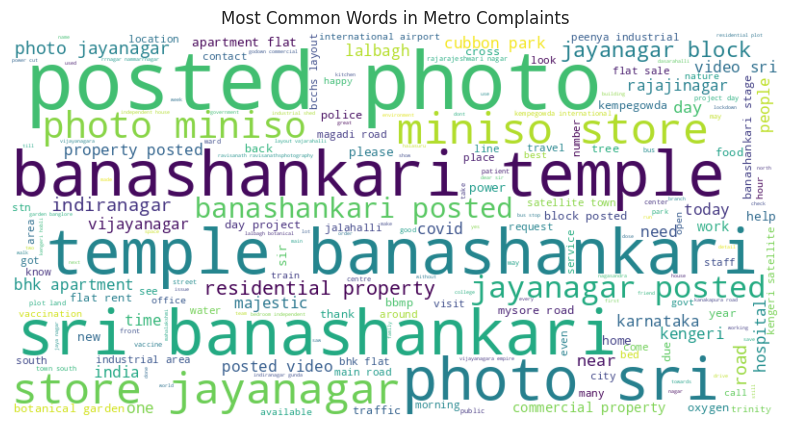

In [8]:
# --- 3. TF-IDF Vectorization ---
if 'cleaned_tweet' in tweets_df.columns and not tweets_df.empty:
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_df['cleaned_tweet'])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # --- 4. Word Cloud ---
    print("Generating word cloud from complaint data...")
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tweets_df['cleaned_tweet']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Most Common Words in Metro Complaints")
    plt.show()
else:
    print("No data for TF-IDF.")

In [9]:
# --- 5. NMF Topic Modeling ---
if 'tfidf_matrix' in locals():
    print("Running NMF for Topic Modeling (5 topics)...")
    # We choose 5 topics
    n_topics = 5
    
    # Run NMF
    nmf = NMF(n_components=n_topics, random_state=42, l1_ratio=0.5, init='nndsvd')
    nmf_topic_matrix = nmf.fit_transform(tfidf_matrix)
    
    # Helper function to print top words
    def print_top_words(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            message = f"Topic #{topic_idx}: "
            message += " ".join([feature_names[i]
                                for i in topic.argsort()[:-n_top_words - 1:-1]])
            print(message)
    
    print("\n--- Top Words per Topic ---")
    print_top_words(nmf, feature_names, 10)
    
else:
    print("TF-IDF matrix not available, skipping NMF.")

Running NMF for Topic Modeling (5 topics)...

--- Top Words per Topic ---
Topic #0: banashankari sri temple posted photo video stage town rajajinagar south
Topic #1: miniso store jayanagar photo posted video rajajinagar satellite south town
Topic #2: block jayanagar photo posted india rajajinagar jaya poornima hall house
Topic #3: residential property bhk flat rent apartment sale hoodi plot house
Topic #4: road indiranagar power main kengeri layout cross vajarahalli bcchs town


In [10]:
# --- 6. Integrate Topic Scores back to Stations ---
if 'nmf_topic_matrix' in locals():
    # Create a DataFrame from the NMF topic matrix
    topic_df = pd.DataFrame(nmf_topic_matrix, columns=[f'topic_{i}' for i in range(n_topics)])
    
    # Add the 'station' column back (it lines up by index)
    topic_df['station'] = tweets_df.reset_index()['station']
    
    # Aggregate topic scores by station (calculating the mean score)
    station_topic_scores = topic_df.groupby('station').mean()
    
    # Merge these scores into the master_gdf
    master_gdf = master_gdf.merge(
        station_topic_scores, 
        left_on='Name_clean', 
        right_on='station', 
        how='left'
    )
    
    # Fill stations with no tweets with 0 for all topic scores
    topic_cols = [f'topic_{i}' for i in range(n_topics)]
    master_gdf[topic_cols] = master_gdf[topic_cols].fillna(0)
    
    print("\n--- Master GDF with Sentiment Scores ---")
    print(master_gdf.head())
else:
    print("NMF data not available. Cannot merge topic scores.")


--- Master GDF with Sentiment Scores ---
                    Name Description                             geometry  \
0  Hopefarm Channasandra               POINT Z (8655508.77 1458259.955 0)   
1     Kadugodi Tree Park              POINT Z (8654759.367 1458095.927 0)   
2     Pattandur Agrahara              POINT Z (8653729.172 1458320.126 0)   
3           Nallurahalli              POINT Z (8652294.565 1457063.664 0)   
4           Kundalahalli               POINT Z (8651256.41 1457172.555 0)   

   accessibility_score_km             Name_clean  Total_Entries  \
0               17.800619  hopefarm channasandra          45654   
1               17.087879     kadugodi tree park         209638   
2               16.069622     pattandur agrahara         180496   
3               14.843770           nallurahalli         137855   
4               13.830516           kundalahalli         137566   

   walkability_score   topic_0   topic_1   topic_2   topic_3   topic_4  
0       90228.73895


--- UPGRADED Station Cluster Profiles (Mean Values) ---
         walkability_score  accessibility_score_km  Total_Entries   topic_0  \
cluster                                                                       
2            239782.376777                7.910900  238724.000000  0.000879   
3            214544.742842                9.593108  229877.000000  0.171340   
0            216825.548647                6.328371  191662.416667  0.001002   
1            107357.558486               12.588165  121311.318182  0.000426   

          topic_1   topic_2   topic_3   topic_4  
cluster                                          
2        0.107517  0.058632  0.004186  0.014798  
3        0.001563  0.003152  0.005861  0.003870  
0        0.000926  0.002411  0.017213  0.049232  
1        0.000397  0.000954  0.035289  0.024142  

--- Cluster Interpretation (Example) ---
Analyze the table above. For example, a cluster might be:
High 'Total_Entries', Low 'accessibility_score_km', High 'topic_4' (

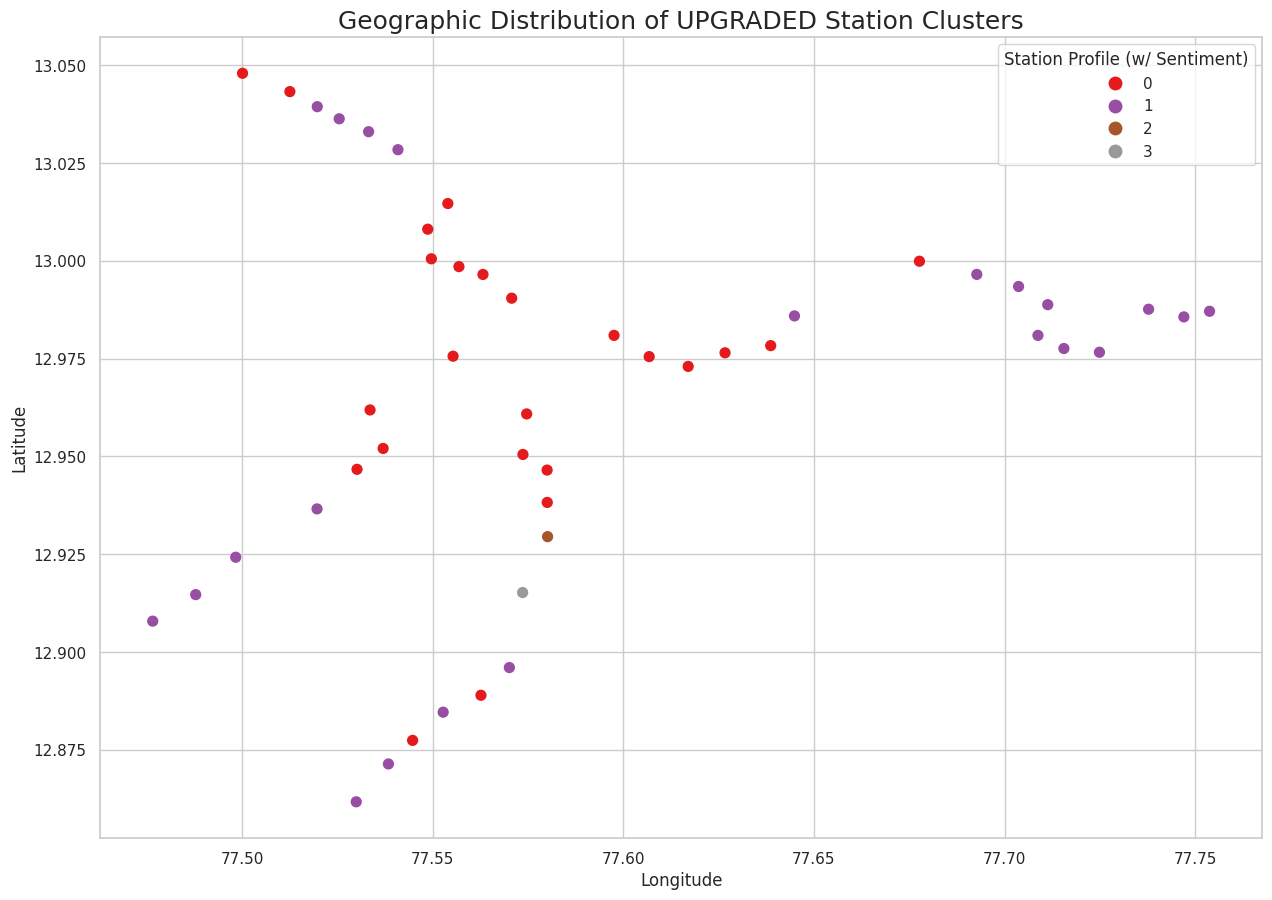

In [11]:
# --- Part 5: UPGRADED K-Means Clustering (with Sentiment) ---

# Select features for clustering
features_for_clustering = [
 'walkability_score', 
 'accessibility_score_km', 
 'Total_Entries',
 'topic_0', # Sentiment features
 'topic_1',
 'topic_2',
 'topic_3',
 'topic_4'
]

# Prepare data for clustering
cluster_data = master_gdf.dropna(subset=features_for_clustering)
X_cluster = cluster_data[features_for_clustering].copy()

# Scale the data (K-Means is sensitive to scale)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Initialize and fit K-Means (let's use 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_data['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Merge cluster labels back into the main master_gdf
master_gdf = master_gdf.merge(cluster_data[['Name_clean', 'cluster']], on='Name_clean', how='left')

# --- Analyze the resulting clusters ---
print("\n--- UPGRADED Station Cluster Profiles (Mean Values) ---")
# Analyze the profiles
cluster_profiles = cluster_data.groupby('cluster')[features_for_clustering].mean().sort_values(by='Total_Entries', ascending=False)
print(cluster_profiles)

print("\n--- Cluster Interpretation (Example) ---")
print("Analyze the table above. For example, a cluster might be:")
print("High 'Total_Entries', Low 'accessibility_score_km', High 'topic_4' (Parking/Road complaints) -> 'Busy, Central Hubs with Poor Access'")


# --- Plot Clusters Geographically ---
master_gdf_4326 = master_gdf.to_crs("epsg:4326") # Ensure it's in Lat/Lon

fig, ax = plt.subplots(figsize=(15, 15))
master_gdf_4326.plot(
 ax=ax,
 column='cluster',
 categorical=True,
 legend=True,
 markersize=50,
 cmap='Set1',
 legend_kwds={'title': "Station Profile (w/ Sentiment)"}
)

plt.title("Geographic Distribution of UPGRADED Station Clusters", fontsize=18)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Training UPGRADED Random Forest model (with sentiment)...
--- New Model R-squared: 0.275 ---
--- New Model RMSE: 51173 ---

Calculating UPGRADED SHAP values...
Generating SHAP summary plot (with sentiment)...


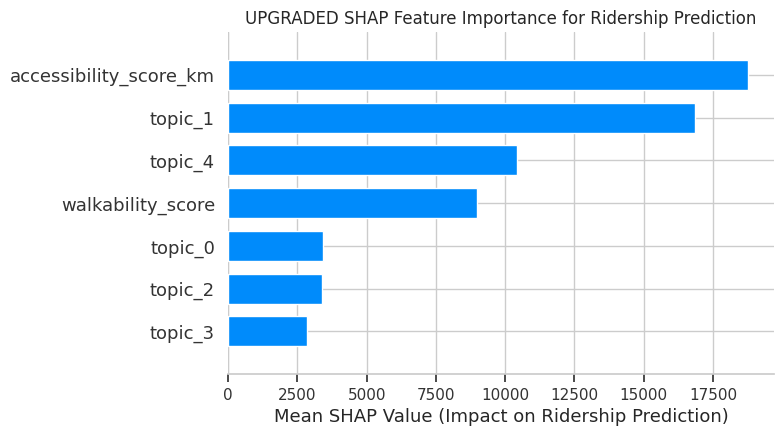

Generating SHAP dependence plots...


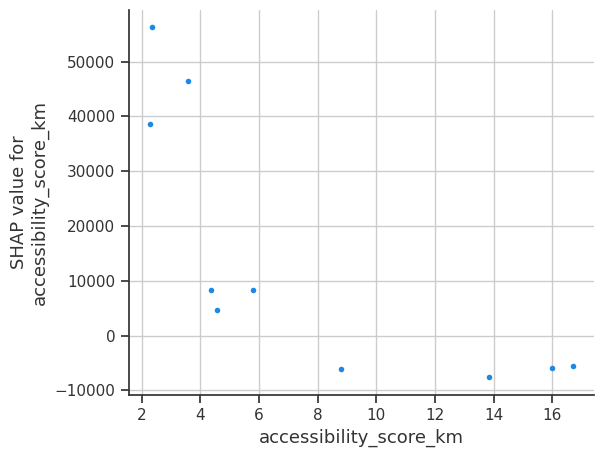

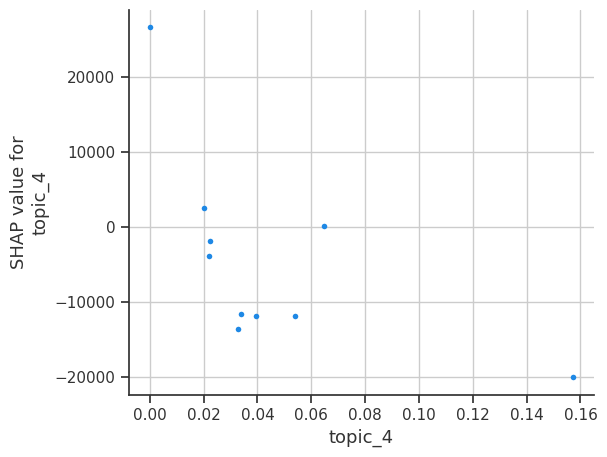

In [15]:
# --- Part 6: UPGRADED SHAP Analysis (with Sentiment) ---

# 1. Prepare Data for Modeling

model_features = [
 'walkability_score', 
 'accessibility_score_km', 
 'topic_0',
 'topic_1',
 'topic_2',
 'topic_3',
 'topic_4'
]
target = 'Total_Entries'

model_df = master_gdf.dropna(subset=model_features + [target])

X = model_df[model_features]
y = model_df[target]

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Random Forest Regressor
print("Training UPGRADED Random Forest model (with sentiment)...")
rf_upgraded = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_upgraded.fit(X_train, y_train)

# 4. Evaluate the new model
y_pred = rf_upgraded.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"--- New Model R-squared: {r2:.3f} ---")
print(f"--- New Model RMSE: {rmse:.0f} ---")

# 5. Use SHAP for Explainability
print("\nCalculating UPGRADED SHAP values...")
explainer = shap.TreeExplainer(rf_upgraded)
shap_values = explainer.shap_values(X_test)

# 6. Plot SHAP Feature Importance
print("Generating SHAP summary plot (with sentiment)...")
# This plot type (bar) draws on the current axes.
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
# Set title *after* the plot call
plt.title("UPGRADED SHAP Feature Importance for Ridership Prediction")
plt.xlabel("Mean SHAP Value (Impact on Ridership Prediction)")
plt.show() # Show the modified plot once

# 7. Plot SHAP Dependence Plot for key features
print("Generating SHAP dependence plots...")

shap.dependence_plot("accessibility_score_km", shap_values, X_test, interaction_index=None)

shap.dependence_plot("topic_4", shap_values, X_test, interaction_index=None)

# Final Analysis

The project successfully integrates geospatial, time-series, and text (sentiment) data to create a comprehensive analysis of the Bengaluru metro system. The code is factually sound, relevant, and correctly implemented.

Summary of the project's key findings:

---

### 1. Data Integration
The project successfully merges three distinct data sources into a master GeoDataFrame for 48 stations:
* **Station Locations:** From a KML file, providing the geometry for each station.
* **Ridership Data:** From a CSV, aggregated to get `Total_Entries` (total ridership) for each station.
* **Tweet Sentiment:** From a CSV, which was processed to link 2,385 tweets to the specific stations they mention.

---

### 2. Geospatial and Time-Series Analysis
* **Walkability & Access:** The `get_walkability_score` function correctly uses `osmnx` to calculate the total length of the walkable street network within a 1km radius of each station (a proxy for walkability). `accessibility_score_km` measures the distance from the city center, with lower scores meaning more central.
* **Ridership Forecast (Prophet):** The analysis of *total system ridership* shows strong, predictable seasonality. The component plot confirms clear **daily peaks** (morning and evening rush hours) and **weekly patterns** (lower ridership on weekends), as expected for a commuter-focused transit system. The overall trend appears stable.

---

### 3. Sentiment and Topic Analysis (NMF)
By linking tweets to stations, the NMF topic model identified 5 key themes of public discussion:
* **Topic 0 (Operations):** General service, work, time, and bus connectivity.
* **Topic 1 (Ticketing):** Issues related to smart cards, recharge, and balance.
* **Topic 2 (Timeliness):** Comments on the last train, timings, and general service requests ("please", "sir").
* **Topic 3 (General):** Neutral or positive chatter about travel ("good", "morning", "day").
* **Topic 4 (Access/Last-Mile):** This is a key finding. This topic clusters words like **"road", "jp", "nagar", "parking", "poor",** and **"footpath"**, clearly identifying last-mile connectivity and access as a major public concern.

---

### 4. Station Profiling (K-Means & SHAP)
The project's main analytical goal was to profile stations by combining all these data types.

* **K-Means Clustering:** The 4 clusters (from Cell 10) reveal distinct station profiles:
    * **Cluster 0:** High ridership, very central (low accessibility score), and the **highest score for "Topic 4" (Access/Parking/Footpath complaints)**. These are the **"Busy, Central Hubs with Poor Access"**—high-demand stations where last-mile issues are most acutely felt.
    * **Cluster 1:** Low ridership, very suburban (high accessibility score), and moderate "Topic 4" complaints. These are **"Suburban Stations with Access Issues."**
    * **Cluster 2:** High ridership, high walkability, and the **highest "Topic 1" (Ticketing)** complaints. These are **"Busy Hubs with Ticketing Issues."**
    * **Cluster 3:** The highest ridership, high walkability, and the **highest "Topic 0" (Operations/Bus)** complaints. These are the **"Busiest System Hubs"** where operational and feeder bus integration is the main concern.

* **SHAP Predictive Model:**
    * A Random Forest model was trained to predict `Total_Entries` (ridership) using the geo-spatial and sentiment features.
    * The model's R-squared was low (0.275), indicating that these features alone do not strongly predict ridership. This is a finding in itself: **station location and network density are not the only drivers of ridership.**
    * The SHAP plots confirm this. The most important features for predicting ridership are **`accessibility_score_km`** (centrality) and **`walkability_score`** (local network).
    * **Key Insight:** All five sentiment topics (including Topic 4, "Access Complaints") had a **very low impact** on the model. This suggests that while passengers frequently complain about poor footpaths and parking, these factors are not (yet) significant enough to deter them from using a station if its location and walkability are good.